<a href="https://colab.research.google.com/github/marcusflygar1-hash/project_testing/blob/main/traffic_project_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# importing the neccesary libraries for the project.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import auc,roc_auc_score,roc_curve, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, r2_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Nya features att addera:

Veckodagar, månad & ?


Gör modellen mer robust, genom att normalisera portal datan.

GridSearchCV? .. tar lång tid dock...



#PCA Function

In [2]:
from sklearn.decomposition import PCA

def pca_anomaly_labeling(df, n_components=3, contamination=0.1):
    """
    Unsupervised anomaly detection using PCA reconstruction error.
    Marks high reconstruction errors (low speeds, unusual patterns) as congestion = 1.
    """
    df = df.copy().dropna(subset=["SPEED_MS_AVG", "FLOW"])
    features = ["SPEED_MS_AVG", "FLOW"]

    # Normalize before PCA
    X = StandardScaler().fit_transform(df[features])

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)

    # Compute reconstruction error
    errors = np.mean((X - X_reconstructed) ** 2, axis=1)
    df["pca_error"] = errors

    # Determine threshold based on contamination fraction (top X% anomalies)
    threshold = np.percentile(errors, 100 * (1 - contamination))
    df["pca_congestion"] = (df["pca_error"] > threshold).astype(int)

    return df, threshold


# Clustering Function

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans_congestion_labeling(df, n_clusters=3):
    """
    Unsupervised labeling using KMeans clustering on SPEED_MS_AVG and FLOW.
    Assigns the cluster with the lowest mean speed as 'congested' (label=1).
    """
    df = df.copy().dropna(subset=["SPEED_MS_AVG", "FLOW"])
    features = ["SPEED_MS_AVG", "FLOW"]

    # Scale the features (important for KMeans)
    X = StandardScaler().fit_transform(df[features])

    # Fit KMeans
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    df["cluster"] = km.fit_predict(X)

    # Find which cluster corresponds to congestion
    cluster_speed_means = df.groupby("cluster")["SPEED_MS_AVG"].mean()
    congested_cluster = cluster_speed_means.idxmin()  # lowest mean speed

    # Assign congestion label: 1 = congested, 0 = non-congested
    df["cluster_congestion"] = (df["cluster"] == congested_cluster).astype(int)

    return df, km, congested_cluster


#DBSCAN Method

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def dbscan_congestion_labeling(df, eps=0.3, min_samples=30):
    """
    Unsupervised congestion labeling using DBSCAN clustering on SPEED_MS_AVG and FLOW.
    Marks sparse/noise points (label = -1) as 'congested' = 1.
    """
    df = df.copy().dropna(subset=["SPEED_MS_AVG", "FLOW"])
    features = ["SPEED_MS_AVG", "FLOW"]

    # Scale features
    X = StandardScaler().fit_transform(df[features])

    # Fit DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples)
    df["db_cluster"] = db.fit_predict(X)

    # DBSCAN assigns -1 to points not belonging to any cluster (noise)
    df["db_congestion"] = (df["db_cluster"] == -1).astype(int)

    return df, db


# Data prepping

In [32]:
tds = pd.read_csv('training_dataset.csv', sep=';')
ev_ds = pd.read_csv('evaluation_dataset.csv',sep=';')
f_ev_ds = pd.read_csv('final_evaluation_dataset.csv', sep=';')


In [33]:
print('\n training dataset')
print(tds.head())
print('\n evaluation dataset------------')
print(ev_ds.head())
print('\n final evaluation dataset --------')
print(f_ev_ds.head())


 training dataset
   DP_ID      PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
0    543  E4S 56,780  20210601  04:00:00         240          48           16   
1    539  E4S 56,160  20210601  04:00:00         240          48           16   
2    534  E4S 56,780  20210601  04:00:00         240          48           16   
3    351  E4S 56,490  20210601  04:00:00         240          48           16   
4    353  E4S 57,055  20210601  04:00:00         240          48           16   

   Interval_30  Interval_60  SPEED_MS_AVG  FLOW  
0            8            4         19.34  10.0  
1            8            4         19.64   9.0  
2            8            4         23.36   5.0  
3            8            4         20.14   7.0  
4            8            4         17.70   7.0  

 evaluation dataset------------
   DP_ID      PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
0   1254  E4S 55,620  20220101  04:00:00         240          48           16   

In [34]:
print('Training dataset')
print(tds.isna().sum())
print('\n eval dataset')
print(ev_ds.isna().sum())
print('\n final eval dataset')
print(f_ev_ds.isna().sum())

Training dataset
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            62
dtype: int64

 eval dataset
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            29
dtype: int64

 final eval dataset
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            4
dtype: int64


In [35]:
#drop all NaN values.
f_ev_ds_noNAN = f_ev_ds.dropna()
tds_noNAN = tds.dropna()
ev_ds_noNAN = ev_ds.dropna()

In [36]:
tds_noNAN.head(10)

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0
5,536,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,28.35,2.0
6,4872,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,16.39,1.0
7,4873,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,15.28,1.0
8,4430,"E4S 57,435",20210601,04:00:00,240,48,16,8,4,18.61,3.0
9,4429,"E4S 57,435",20210601,04:00:00,240,48,16,8,4,23.33,1.0


In [73]:
#Filter all of the datasets so we only have data from the correct portal / sensor group
#This will ensure we can get more reliable data as the predicitons just do not work when they are all together.

portal_of_interest = "E4S 56,780"
tds_noNAN = tds_noNAN[tds_noNAN['PORTAL'] == portal_of_interest]
ev_ds_noNAN = ev_ds_noNAN[ev_ds_noNAN['PORTAL'] == portal_of_interest]
f_ev_ds_noNAN = f_ev_ds_noNAN[f_ev_ds_noNAN['PORTAL'] == portal_of_interest]
print(f"Training rows for {portal_of_interest}: {len(tds_noNAN)}")
print(f"Evaluation rows for {portal_of_interest}: {len(ev_ds_noNAN)}")
print(f"Final Evaluation rows for {portal_of_interest}: {len(f_ev_ds_noNAN)}")

Training rows for E4S 56,780: 272954
Evaluation rows for E4S 56,780: 114106
Final Evaluation rows for E4S 56,780: 117117


In [38]:
print(f'Org dataset amount:{len(tds)}')
print(f'Org dataset amount:{len(ev_ds)}')
print(f'Org dataset amount:{len(f_ev_ds)}')

print(f'Dropped Dataset amount:{len(tds_noNAN)}')
print(f'Dropped Dataset amount:{len(ev_ds_noNAN)}')
print(f'Dropped Dataset amount:{len(f_ev_ds_noNAN)}')

Org dataset amount:1921967
Org dataset amount:803377
Org dataset amount:803501
Dropped Dataset amount:272954
Dropped Dataset amount:114106
Dropped Dataset amount:117117


# Forts.

In [39]:
#define what is congestion and what is not.
# congestion_flow = tds[tds['FLOW'] < 100]
# congestion_speed = tds[tds['SPEED_MS_AVG'] < 10]

ev_ds_noNAN['datetime'] = pd.to_datetime(ev_ds_noNAN['Date'].astype(str) + ' ' + ev_ds_noNAN['Time'])

ev_ds_offpeak = ev_ds_noNAN[(ev_ds_noNAN['datetime'].dt.time >= pd.to_datetime("04:00:00").time()) &
                            (ev_ds_noNAN['datetime'].dt.time <= pd.to_datetime("06:00:00").time())]
ev_ds_onpeak = ev_ds_noNAN[(ev_ds_noNAN['datetime'].dt.time >= pd.to_datetime("07:30:00").time()) &
                           (ev_ds_noNAN['datetime'].dt.time <= pd.to_datetime("08:30:00").time())]

ev_ds_offpeak = ev_ds_offpeak[(ev_ds_offpeak['FLOW'] > 0) &
                              (ev_ds_offpeak['SPEED_MS_AVG'].between(5, 50))]
ev_ds_onpeak = ev_ds_onpeak[(ev_ds_onpeak['FLOW'] > 0) &
                            (ev_ds_onpeak['SPEED_MS_AVG'].between(5, 50))]


In [40]:
# converting the date and time columns int o just one "datetime" coluinm
tds_noNAN['datetime'] = pd.to_datetime(tds_noNAN['Date'].astype(str) + ' ' + tds_noNAN['Time'])

# filtering the dataset to only include the data within hours 04:00 and 06:00, this to get an accurate description of free flow speed.
tds_offpeak = tds_noNAN[(tds_noNAN['datetime'].dt.time >= pd.to_datetime("04:00:00").time()) &
                (tds_noNAN['datetime'].dt.time <= pd.to_datetime("06:00:00").time())]

tds_onpeak= tds_noNAN[(tds_noNAN['datetime'].dt.time >= pd.to_datetime("07:30:00").time()) &
                  (tds_noNAN['datetime'].dt.time <= pd.to_datetime("08:30:00").time())]
#Ensuring we only get correctly read speeds. E.g Removing any negative speeds and random slow drivers etc
#that do not actually depict the actual free flowspeed e.g people speeding and drinving super slow...
tds_offpeak = tds_offpeak[(tds_offpeak['FLOW'] > 0) &
                        (tds_offpeak['SPEED_MS_AVG'].between(2, 50))]
tds_onpeak = tds_onpeak[(tds_onpeak['FLOW'] > 0) &
                        (tds_onpeak['SPEED_MS_AVG'].between(2, 50))]

In [41]:
#defining what congestion is for off peak hours
ffs_kmh = 85 #Through basic theory, a 4 lane road with a speed limit of 70 km/h, would have the free flow speed around 85 km/h
ffs_ms = ffs_kmh * 0.277778 # Converting km/h to m/s
cong_th = (ffs_kmh * 0.7) # We use mild congestion as a staple, as otherwise the dataset for congested times is just to small to work with.
print(f"Free flow speed in [km/h]: {ffs_kmh}")
print(f"Free flow speed in [m/s]: {ffs_ms}")
print(f"Congestion Speed Threshold [km/h]: {cong_th}")

#hard coding cong as 60 [km/h] for simplicty
cong_th_2 = 60

Free flow speed in [km/h]: 85
Free flow speed in [m/s]: 23.611130000000003
Congestion Speed Threshold [km/h]: 59.49999999999999


In [42]:
#defining what congestion is for on peak hours
ffs_kmh_2 = 85 #Through basic theory, a 4 lane road with a speed limit of 70 km/h, would have the free flow speed around 85 km/h
ffs_ms_2 = ffs_kmh_2 * 0.277778 # Converting km/h to m/s
cong_th_2 = (ffs_kmh_2 * 0.7) # We use mild congestion as a staple, as otherwise the dataset for congested times is just to small to work with.
print(f"Free flow speed in [km/h]: {ffs_kmh_2}")
print(f"Free flow speed in [m/s]: {ffs_ms_2}")
print(f"Congestion Speed Threshold [km/h]: {cong_th_2}")

#hard coding cong as 61 [km/h] for simplicty and to catch those going around 60km/h for a fairer comparison
cong_th_2 = 61

Free flow speed in [km/h]: 85
Free flow speed in [m/s]: 23.611130000000003
Congestion Speed Threshold [km/h]: 59.49999999999999


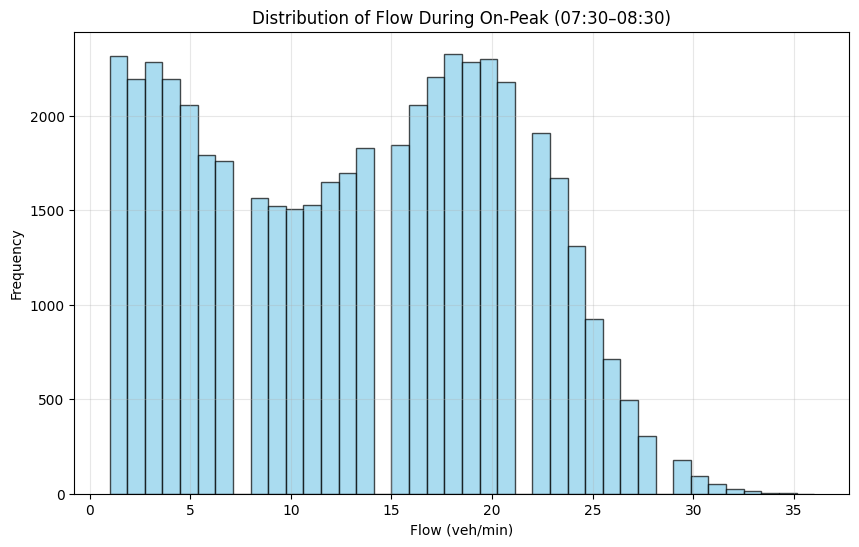

In [89]:
#Distribution of flows during on peak hours
plt.figure(figsize=(10,6))
plt.hist(tds_onpeak['FLOW'], bins=40, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Flow (veh/min)') # Corrected xlabel
plt.ylabel("Frequency")
plt.title("Distribution of Flow During On-Peak (07:30–08:30)") # Corrected title
# plt.legend() # Removed legend call as no labels are defined
plt.grid(alpha=0.3)
plt.show()

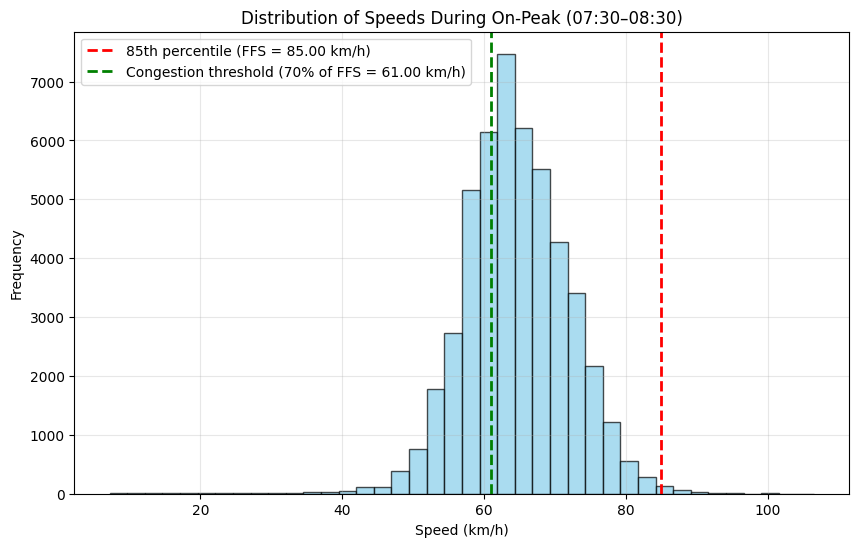

In [43]:
#Distribution of speeds during on peak hours
plt.figure(figsize=(10,6))
plt.hist(tds_onpeak['SPEED_MS_AVG']*3.6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(ffs_kmh_2, color='red', linestyle='--', linewidth=2, label=f'85th percentile (FFS = {ffs_kmh_2:.2f} km/h)')
plt.axvline(cong_th_2, color='green', linestyle='--', linewidth=2, label=f'Congestion threshold (70% of FFS = {cong_th_2:.2f} km/h)')
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds During On-Peak (07:30–08:30)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

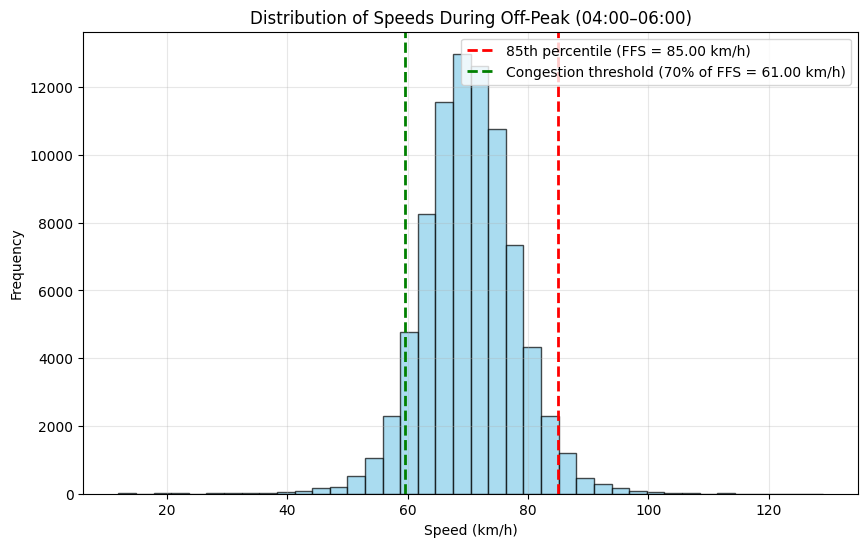

In [44]:
#dist of speeds during off peak hours.

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(tds_offpeak['SPEED_MS_AVG']*3.6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(ffs_kmh, color='red', linestyle='--', linewidth=2, label=f'85th percentile (FFS = {ffs_kmh:.2f} km/h)')
plt.axvline(cong_th, color='green', linestyle='--', linewidth=2, label=f'Congestion threshold (70% of FFS = {cong_th_2:.2f} km/h)')



plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds During Off-Peak (04:00–06:00)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [45]:
print(cong_th_2)
tds_onpeak.info()

61
<class 'pandas.core.frame.DataFrame'>
Index: 48791 entries, 5517 to 1919597
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DP_ID         48791 non-null  int64         
 1   PORTAL        48791 non-null  object        
 2   Date          48791 non-null  int64         
 3   Time          48791 non-null  object        
 4   Interval_1    48791 non-null  int64         
 5   Interval_5    48791 non-null  int64         
 6   Interval_15   48791 non-null  int64         
 7   Interval_30   48791 non-null  int64         
 8   Interval_60   48791 non-null  int64         
 9   SPEED_MS_AVG  48791 non-null  float64       
 10  FLOW          48791 non-null  float64       
 11  datetime      48791 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(7), object(2)
memory usage: 4.8+ MB


In [46]:
#Creat our rolling and shifting.
tds_onpeak['pred15'] = tds_onpeak['SPEED_MS_AVG'].shift(-1).rolling(15).mean()
tds_onpeak['congestion'] = (tds_onpeak['pred15']*3.6 <= cong_th_2).astype(int)

In [47]:
tds_onpeak["speed_norm"] = (
    tds_onpeak.groupby("DP_ID")["SPEED_MS_AVG"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

ev_ds_onpeak["speed_norm"] = (
    ev_ds_onpeak.groupby("DP_ID")["SPEED_MS_AVG"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

# Methods for classification

## pca Version

In [30]:
tds_pca, error_threshold = pca_anomaly_labeling(tds_onpeak, n_components=2, contamination=0.15)
print(f"PCA anomaly threshold: {error_threshold:.6f}")
print(tds_pca["pca_congestion"].value_counts())


PCA anomaly threshold: 0.000000
pca_congestion
0    42176
1     6615
Name: count, dtype: int64


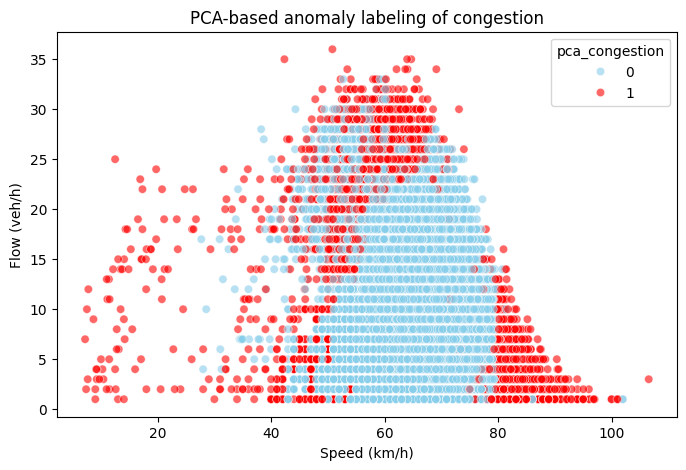

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=tds_pca["SPEED_MS_AVG"]*3.6,
    y=tds_pca["FLOW"],
    hue=tds_pca["pca_congestion"],
    palette={0:"skyblue",1:"red"},
    alpha=0.6
)
plt.xlabel("Speed (km/h)")
plt.ylabel("Flow (veh/h)")
plt.title("PCA-based anomaly labeling of congestion")
plt.show()


## Clustering Version

In [21]:
tds_cluster, kmeans_model, congested_cluster = kmeans_congestion_labeling(tds_onpeak, n_clusters=3)
print("Congested cluster:", congested_cluster)
print(tds_cluster["cluster_congestion"].value_counts())


Congested cluster: 2
cluster_congestion
0    38384
1    10407
Name: count, dtype: int64


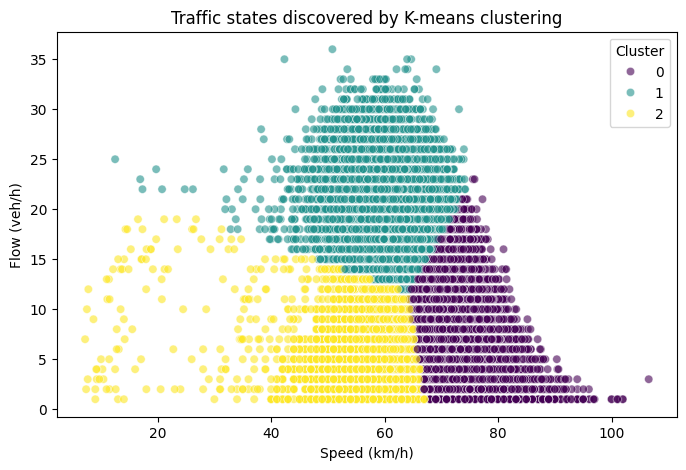

In [22]:
#visualisation of clusters
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=tds_cluster,
    x=tds_cluster["SPEED_MS_AVG"]*3.6,  # convert to km/h
    y=tds_cluster["FLOW"],
    hue=tds_cluster["cluster"],
    palette="viridis",
    alpha=0.6
)
plt.xlabel("Speed (km/h)")
plt.ylabel("Flow (veh/h)")
plt.title("Traffic states discovered by K-means clustering")
plt.legend(title="Cluster")
plt.show()


## DBSCAN Method

In [21]:
tds_db, db_model = dbscan_congestion_labeling(tds_onpeak, eps=0.25, min_samples=20)
print(tds_db["db_congestion"].value_counts())


db_congestion
0    48511
1      280
Name: count, dtype: int64


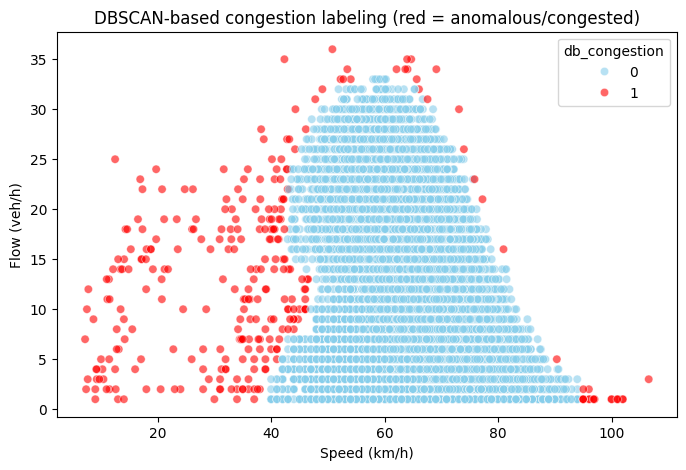

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=tds_db["SPEED_MS_AVG"] * 3.6,  # convert m/s → km/h
    y=tds_db["FLOW"],
    hue=tds_db["db_congestion"],
    palette={0:"skyblue", 1:"red"},
    alpha=0.6
)
plt.xlabel("Speed (km/h)")
plt.ylabel("Flow (veh/h)")
plt.title("DBSCAN-based congestion labeling (red = anomalous/congested)")
plt.show()


# Hard constrained function

In [48]:
#function where the features are created and..
def make_features_targets(df, horizon=15, window=15, cong_th_2=61):
    df = df.copy()
    df = df.sort_values("datetime")

    # Ensure so the df is in datetime and not Date and Time..
    if "datetime" not in df.columns:
        df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"])

    # Rolling past features
    df["past_mean_speed"] = df["SPEED_MS_AVG"].rolling(window).mean()
    df["past_std_speed"] = df["SPEED_MS_AVG"].rolling(window).std()
    df["past_min_speed"] = df["SPEED_MS_AVG"].rolling(window).min()

    df["past_mean_flow"] = df["FLOW"].rolling(window).mean()
    df["past_std_flow"] = df["FLOW"].rolling(window).std()

    # Trend & instability
    df["past_speed_trend"] = df["SPEED_MS_AVG"] - df["SPEED_MS_AVG"].rolling(window).mean()
    df["flow_to_speed_ratio"] = df["past_mean_flow"] / (df["past_mean_speed"] + 1e-3)

    # Share of low-speed observations
    df["share_low_speed"] = (
        (df["SPEED_MS_AVG"] * 3.6 < cong_th_2)
        .rolling(window)
        .mean()
    )

    # tem.poral features.
    df["hour"] = df["datetime"].dt.hour
    df["month"] = df["datetime"].dt.month
    df["dayofweek"] = df["datetime"].dt.dayofweek

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    # target, future congestion. Hard constrained to our cong_th_2
    future_speed = df["SPEED_MS_AVG"].shift(-horizon).rolling(horizon).mean()
    df["future_congestion"] = (future_speed * 3.6 < cong_th_2).astype(int)

    # Speed and flow deltas
    df["speed_delta_5min"] = df["SPEED_MS_AVG"] - df["SPEED_MS_AVG"].shift(5)
    df["flow_delta_5min"] = df["FLOW"] - df["FLOW"].shift(5)

    # Rolling slope of speed
    df["speed_slope"] = (
    df["SPEED_MS_AVG"].rolling(5)
      .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=False)
    )

    # dropping eventual nans created during the process
    df = df.dropna().reset_index(drop=True)

    #features included
    features = [
        "past_mean_speed", "past_std_speed", "past_min_speed",
        "past_mean_flow", "past_std_flow",
        "past_speed_trend", "flow_to_speed_ratio",
        "share_low_speed",
        "hour_sin", "hour_cos",
        "month_sin", "month_cos",
        "dow_sin", "dow_cos",'speed_slope','speed_delta_5min','flow_delta_5min']

    target = "future_congestion"

    return df, features, target


## Initate the methods

Run only one, aka the chosen method code block.

In [49]:
tds_fixad, features, target = make_features_targets(tds_onpeak, horizon=15, cong_th_2=cong_th_2)

# Create evaluation data (for 2022)
ev_fixad, _, _ = make_features_targets(ev_ds_onpeak, horizon=15, cong_th_2=cong_th_2)

In [33]:
tds_pca, error_threshold = pca_anomaly_labeling(tds_onpeak, n_components=2, contamination=0.15)
tds_fixad, features, target = make_features_targets(tds_pca, horizon=15)
tds_fixad["future_congestion"] = tds_pca["pca_congestion"].iloc[:len(tds_fixad)].values


In [24]:
tds_cluster, _, _ = kmeans_congestion_labeling(tds_onpeak, n_clusters=3)
tds_fixad, features, target = make_features_targets(tds_cluster, horizon=15)
tds_fixad["future_congestion"] = tds_cluster["cluster_congestion"].iloc[:len(tds_fixad)].values


In [24]:
tds_db, db_model = dbscan_congestion_labeling(tds_onpeak, eps=0.25, min_samples=20)
tds_fixad, features, target = make_features_targets(tds_db, horizon=15)
tds_fixad["future_congestion"] = tds_db["db_congestion"].iloc[:len(tds_fixad)].values


# Dela upp i train test splits.

In [50]:
#Split into train / test sets
X = tds_fixad[features].values
y = tds_fixad[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
#Scaling the datat.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Test data models

In [51]:
from sklearn.linear_model import LogisticRegression

#Logistic regression model.
lr = LogisticRegression(random_state = 42, max_iter = 1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Dataset")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=3))
print(f" The roc_auc score is: {roc_auc_score(y_test, y_prob_lr)}")

Logistic Regression Dataset
[[3296 3192]
 [  43 3224]]
              precision    recall  f1-score   support

           0      0.987     0.508     0.671      6488
           1      0.502     0.987     0.666      3267

    accuracy                          0.668      9755
   macro avg      0.745     0.747     0.668      9755
weighted avg      0.825     0.668     0.669      9755

 The roc_auc score is: 0.9012393957887737


In [52]:
print("Class distribution in y_train:")
print(pd.Series(y_train).value_counts())

Class distribution in y_train:
0    34038
1     4981
Name: count, dtype: int64


In [53]:
print("Class distribution in tds_fixad['future_congestion']:")
print(tds_fixad['future_congestion'].value_counts())

Class distribution in tds_fixad['future_congestion']:
future_congestion
0    40526
1     8248
Name: count, dtype: int64


In [54]:
from xgboost import XGBClassifier
#Xgboos classifier.
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
    )

xgb_clf.fit(X_train_scaled, y_train)

# Predict.
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_prob_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]


# stats
print("XGBoost Training dataset")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=3))

XGBoost Training dataset
[[4455 2033]
 [ 106 3161]]
              precision    recall  f1-score   support

           0      0.977     0.687     0.806      6488
           1      0.609     0.968     0.747      3267

    accuracy                          0.781      9755
   macro avg      0.793     0.827     0.777      9755
weighted avg      0.853     0.781     0.787      9755



In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    class_weight='balanced',  # handle the class imbalance
    random_state=42,
    n_jobs=-1 #n_jobs help using all cores.
    )

rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)
#stats
print("Random Forest Training dataset")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

Random Forest Training dataset
[[5179 1309]
 [ 440 2827]]
              precision    recall  f1-score   support

           0      0.922     0.798     0.856      6488
           1      0.684     0.865     0.764      3267

    accuracy                          0.821      9755
   macro avg      0.803     0.832     0.810      9755
weighted avg      0.842     0.821     0.825      9755



In [56]:
from sklearn.svm import SVC
#Support vector classifier.
svm = SVC(
    kernel='rbf',
    probability=True,
    C=1.0,
    gamma='scale',
    random_state=42
)

svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]

#stats

In [64]:
print('SVM Training Dataset')
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=3))

SVM Training Dataset
[[5497  991]
 [ 952 2315]]
              precision    recall  f1-score   support

           0      0.852     0.847     0.850      6488
           1      0.700     0.709     0.704      3267

    accuracy                          0.801      9755
   macro avg      0.776     0.778     0.777      9755
weighted avg      0.801     0.801     0.801      9755



In [62]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', n_jobs=-1) # You can adjust n_neighbors
knn_clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn_clf.predict(X_test_scaled)

# Print evaluation metrics
print("K-Nearest Neighbors Training dataset")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, digits=3))

K-Nearest Neighbors Training dataset
[[5684  804]
 [1732 1535]]
              precision    recall  f1-score   support

           0      0.766     0.876     0.818      6488
           1      0.656     0.470     0.548      3267

    accuracy                          0.740      9755
   macro avg      0.711     0.673     0.683      9755
weighted avg      0.730     0.740     0.727      9755



In [57]:
print("Logistic Regression Dataset")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=3))
print("\n")

print("XGBoost Training dataset")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=3))
print("\n")
print("Random Forest Training dataset")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))
print("\n")
print("SVM Training dataset")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=3))
print('\n')
print("K-Nearest Neighbors Training dataset")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, digits=3))

Logistic Regression Dataset
[[3296 3192]
 [  43 3224]]
              precision    recall  f1-score   support

           0      0.987     0.508     0.671      6488
           1      0.502     0.987     0.666      3267

    accuracy                          0.668      9755
   macro avg      0.745     0.747     0.668      9755
weighted avg      0.825     0.668     0.669      9755



XGBoost Training dataset
[[4455 2033]
 [ 106 3161]]
              precision    recall  f1-score   support

           0      0.977     0.687     0.806      6488
           1      0.609     0.968     0.747      3267

    accuracy                          0.781      9755
   macro avg      0.793     0.827     0.777      9755
weighted avg      0.853     0.781     0.787      9755



Random Forest Training dataset
[[5179 1309]
 [ 440 2827]]
              precision    recall  f1-score   support

           0      0.922     0.798     0.856      6488
           1      0.684     0.865     0.764      3267

    accuracy 

In [78]:
#create empty list to store results
results = []

#for loop that adds results to the list "results"
for name, pred in [
    ("Logistic Regression", y_pred_lr),
    ("Random Forest", y_pred_rf),
    ("XGBoost", y_pred_xgb),
    ("SVM", y_pred_svm),
    ("K-Nearest Neighbors", y_pred_knn)
]:
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred)
    })

results_df = pd.DataFrame(results)
#print the results.
print(results_df)

                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.668375   0.502494  0.986838  0.665909
1        Random Forest  0.820707   0.683511  0.865320  0.763744
2              XGBoost  0.780728   0.608587  0.967554  0.747193
3                  SVM  0.800820   0.700242  0.708601  0.704397
4  K-Nearest Neighbors  0.740031   0.656263  0.469850  0.547628


# Evaluation data models

In [59]:
#call function to fix ev_ds_onpeak dataset to contain the same features.
ev_fixad, _, _ = make_features_targets(ev_ds_onpeak, horizon=15, cong_th_2=cong_th_2)

In [60]:
#running the models on the evaluation dataset.
X_eval = ev_fixad[features].values
y_eval = ev_fixad[target].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_eval_scaled  = scaler.transform(X_eval)

from sklearn.metrics import confusion_matrix, classification_report

for name, model in [
    ("Logistic Regression", lr),
    ("Random Forest", rf_clf),
    ("XGBoost", xgb_clf),
    ("SVM", svm)
]:
    y_pred_eval = model.predict(X_eval_scaled)
    print(f"\n{name} (Evaluation 2022 dataset):")
    print(confusion_matrix(y_eval, y_pred_eval))
    print(classification_report(y_eval, y_pred_eval, digits=3))



Logistic Regression (Evaluation 2022 dataset):
[[9128 8864]
 [ 110 2089]]
              precision    recall  f1-score   support

           0      0.988     0.507     0.670     17992
           1      0.191     0.950     0.318      2199

    accuracy                          0.556     20191
   macro avg      0.589     0.729     0.494     20191
weighted avg      0.901     0.556     0.632     20191


Random Forest (Evaluation 2022 dataset):
[[16769  1223]
 [  748  1451]]
              precision    recall  f1-score   support

           0      0.957     0.932     0.944     17992
           1      0.543     0.660     0.596      2199

    accuracy                          0.902     20191
   macro avg      0.750     0.796     0.770     20191
weighted avg      0.912     0.902     0.906     20191


XGBoost (Evaluation 2022 dataset):
[[13533  4459]
 [  432  1767]]
              precision    recall  f1-score   support

           0      0.969     0.752     0.847     17992
           1      0.28

In [61]:
#loop through models on evaluation dataset.
for name, model in [
    ("Logistic Regression", lr),
    ("Random Forest", rf_clf),
    ("XGBoost", xgb_clf),
    ("SVM", svm)
]:
    y_pred_eval = model.predict(X_eval_scaled)
    print(f"\n{name} (Evaluation 2022 dataset):")
    print(confusion_matrix(y_eval, y_pred_eval))
    print(classification_report(y_eval, y_pred_eval, digits=3))


Logistic Regression (Evaluation 2022 dataset):
[[9128 8864]
 [ 110 2089]]
              precision    recall  f1-score   support

           0      0.988     0.507     0.670     17992
           1      0.191     0.950     0.318      2199

    accuracy                          0.556     20191
   macro avg      0.589     0.729     0.494     20191
weighted avg      0.901     0.556     0.632     20191


Random Forest (Evaluation 2022 dataset):
[[16769  1223]
 [  748  1451]]
              precision    recall  f1-score   support

           0      0.957     0.932     0.944     17992
           1      0.543     0.660     0.596      2199

    accuracy                          0.902     20191
   macro avg      0.750     0.796     0.770     20191
weighted avg      0.912     0.902     0.906     20191


XGBoost (Evaluation 2022 dataset):
[[13533  4459]
 [  432  1767]]
              precision    recall  f1-score   support

           0      0.969     0.752     0.847     17992
           1      0.28


Evaluating models on f_ev_ds (threshold labels):

Logistic Regression (Final Evaluation f_ev_ds with threshold labels):
[[82548 26640]
 [  483  7432]]
              precision    recall  f1-score   support

           0      0.994     0.756     0.859    109188
           1      0.218     0.939     0.354      7915

    accuracy                          0.768    117103
   macro avg      0.606     0.847     0.606    117103
weighted avg      0.942     0.768     0.825    117103

F1-score: 0.354

Random Forest (Final Evaluation f_ev_ds with threshold labels):
[[105411   3777]
 [  2891   5024]]
              precision    recall  f1-score   support

           0      0.973     0.965     0.969    109188
           1      0.571     0.635     0.601      7915

    accuracy                          0.943    117103
   macro avg      0.772     0.800     0.785    117103
weighted avg      0.946     0.943     0.944    117103

F1-score: 0.601

XGBoost (Final Evaluation f_ev_ds with threshold labels):
[[9

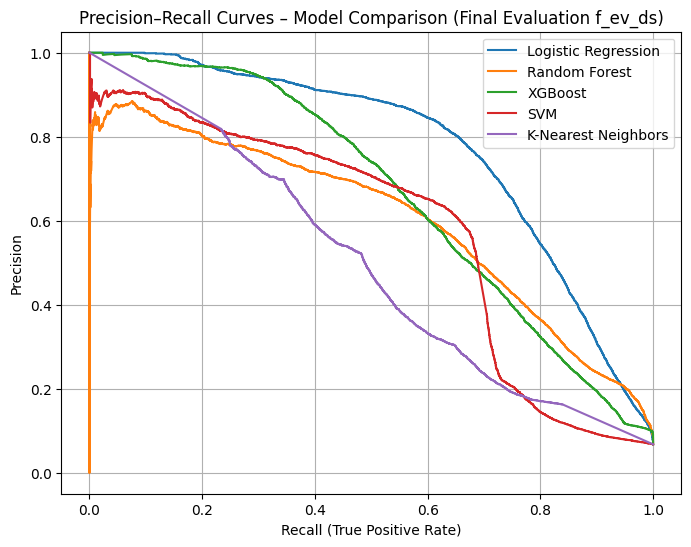

In [72]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
# Filter the final evaluation dataset by the portal of interest
f_ev_ds_portal = f_ev_ds[f_ev_ds['PORTAL'] == portal_of_interest].copy()

# Drop NaNs from f_ev_ds_portal before feature engineering
f_ev_ds_cleaned = f_ev_ds_portal.dropna(subset=["SPEED_MS_AVG", "FLOW"]).copy()

# Ensure datetime is present
if "datetime" not in f_ev_ds_cleaned.columns:
    f_ev_ds_cleaned["datetime"] = pd.to_datetime(f_ev_ds_cleaned["Date"].astype(str) + " " + f_ev_ds_cleaned["Time"])

# Filter again for peak hours
f_ev_ds_onpeak = f_ev_ds_cleaned[
    (f_ev_ds_cleaned['datetime'].dt.time >= pd.to_datetime("07:30:00").time()) &
    (f_ev_ds_cleaned['datetime'].dt.time <= pd.to_datetime("08:30:00").time())
].copy()

# Use the make_features_targets function on the filtered (onpeak) data set for final evaluation.
f_ev_fixad, features_eval, target_eval = make_features_targets(
    f_ev_ds_onpeak, horizon=15, cong_th_2=cong_th_2
)


X_final_eval = f_ev_fixad[features_eval].values
y_final_eval = f_ev_fixad[target_eval].values

#Scaling final evaluation data.
# Scaler for threshold.
scaler_threshold = StandardScaler()
X_train_threshold = tds_fixad[features_eval].values
scaler_threshold.fit(X_train_threshold)
X_final_eval_scaled = scaler_threshold.transform(X_final_eval)


# Evaluation of traning models on the final evaluation dataset
print("\nEvaluating models on f_ev_ds (threshold labels):")
# Use the models trained with the threshold-based labels (lr, rf_clf, xgb_clf from earlier cells)
models_threshold = [("Logistic Regression", lr), ("Random Forest", rf_clf), ("XGBoost", xgb_clf), ("SVM", svm), ("K-Nearest Neighbors", knn_clf)]

# Get probability predictions for each model on the final evaluation dataset
y_prob_final_eval = {}
for name, model in models_threshold:
    y_pred_final_eval = model.predict(X_final_eval_scaled)
    y_prob_final_eval[name] = model.predict_proba(X_final_eval_scaled)[:, 1]

    print(f"\n{name} (Final Evaluation f_ev_ds with threshold labels):")
    print(confusion_matrix(y_final_eval, y_pred_final_eval))
    print(classification_report(y_final_eval, y_pred_final_eval, digits=3))
    print("F1-score:", round(f1_score(y_final_eval, y_pred_final_eval), 3))

#Visualizations

## Training Data Visualisations.

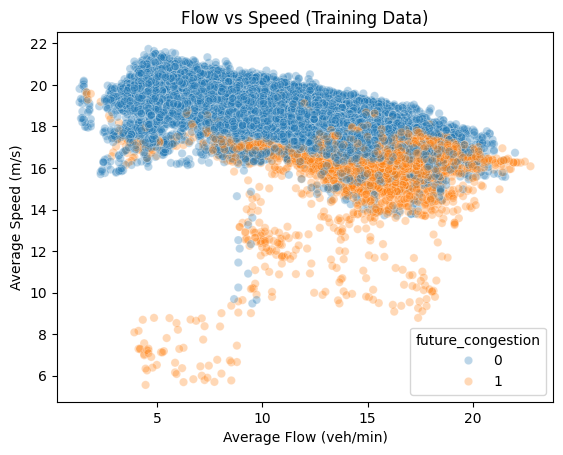

In [79]:
#Scatter plot, flow vs speed on training data.
sns.scatterplot(
    data=tds_fixad,
    x='past_mean_flow',
    y='past_mean_speed',
    hue='future_congestion',
    alpha=0.3
)
plt.title('Flow vs Speed (Training Data)')
plt.xlabel('Average Flow (veh/min)')
plt.ylabel('Average Speed (m/s)')
plt.show()

##Evaluation set 1 visualisations

## Final Evaluation set visualisations.


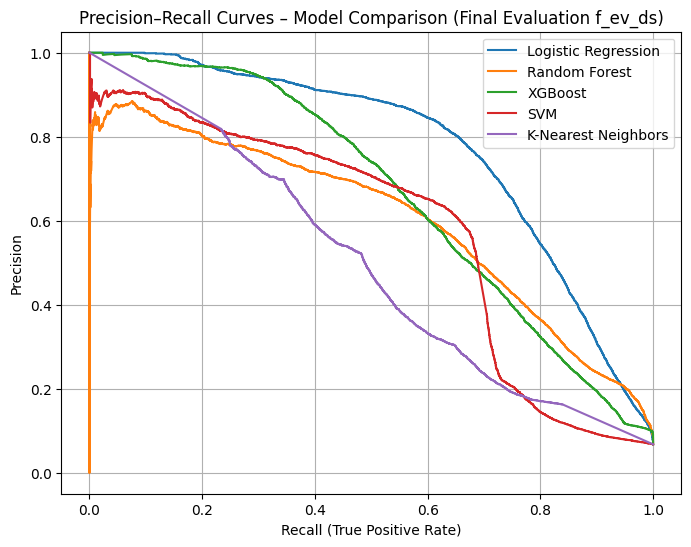

In [80]:
#percision and recall curves for the final evaluation dataset
plt.figure(figsize=(8, 6))

for name, y_prob in y_prob_final_eval.items():
    prec, rec, thr = precision_recall_curve(y_final_eval, y_prob)
    plt.plot(rec, prec, label=name)

plt.xlabel("Recall (True Positive Rate)")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Model Comparison (Final Evaluation f_ev_ds)")
plt.legend()
plt.grid(True)
plt.show()

In [81]:

# Get feature importances from the trained Random Forest
importances = rf_clf.feature_importances_

# Combine with feature names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))


                Feature  Importance
0       past_mean_speed    0.258348
7       share_low_speed    0.152150
2        past_min_speed    0.115946
12              dow_sin    0.085735
6   flow_to_speed_ratio    0.066558
4         past_std_flow    0.049448
1        past_std_speed    0.045369
3        past_mean_flow    0.043427
11            month_cos    0.034170
10            month_sin    0.030346


In [84]:

# Get feature importances from the trained Random Forest
importances = xgb_clf.feature_importances_

# Combine with feature names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))


            Feature  Importance
0   past_mean_speed    0.276410
7   share_low_speed    0.146479
12          dow_sin    0.097999
10        month_sin    0.058643
11        month_cos    0.053022
2    past_min_speed    0.045039
13          dow_cos    0.044471
9          hour_cos    0.038974
8          hour_sin    0.036154
4     past_std_flow    0.034469


In [82]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_clf, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

for idx in sorted_idx[:10]:
    print(features[idx], result.importances_mean[idx])


past_mean_speed 0.10753459764223476
past_min_speed 0.04119938493080474
share_low_speed 0.0334700153767299
dow_sin 0.028590466427473094
flow_delta_5min 0.001291645310097389
dow_cos 0.0008200922603793015
flow_to_speed_ratio 0.00038954382368019405
past_std_flow 0.00025627883136853936
past_speed_trend 0.00015376729882110585
hour_sin 8.200922603791571e-05
